# Sadržaj
[Uvod](#Uvod) <br>
[Kreiranje ploče](#Kreiranje-ploče)

# Uvod
U ovom radu je opisan proces implementiranja verzije šaha pod nazivom *Silvermann 4x5*. Cilj je napraviti umjetnu inteligenciju koja može igrati protiv korisnika softvera.

**PRAVILA SILVERMANN 4X5 ŠAHA**:
* Pravila su gotovo ista kao kod [klasičnog šaha](https://hr.wikipedia.org/wiki/%C5%A0ah). Ovo su jedine preomjene:
    * U igri se koriste samo kralj, kraljica, kula i pijuni.
    * Igra se na polju dimenzije 4 x 5 (vidi implementaciju funkcije za crtanje ploče).
    * Pijuni se promoviraju isključivo u kraljicu.
    * Rošada se izvodi tako da kralj i kula zamjene mjesta ako između njih nema drugih figura. Ostala pravila u vezi rošade ostaju ista.
    * Pijun se može pomaknuti dva polja unaprijed samo ako na ciljnoj poziciji ne postoji druga figura. *En passant* uzimanje pijunom je dozvoljeno nakon toga.

# Kreiranje ploče
Prvi korak je napisati klasu koja se brine o pravilima i pohrani informacija o stanju igre.<br>
Znakovi `'K', 'Q', 'R', 'P', 'k', 'q', 'r', 'p'` se koriste za programsku logiku i reprezentaciju figura u memoriji. Rječnik `color` specificira boju figura. `icon_old` je bio korišten u staroj verziji crtanja ploče.


In [147]:
icon_old = {
    #white pieces
    'K': " \u20ad ",
    'Q': " \u03a6 ",
    'R': " \u01a6 ",
    'P': " I ",
    #black pieces
    'k': " k ",
    'q': " q ",
    'r': " r ",
    'p': " i ",
    #empty spaces
    '.': "   ",
    #special
    '-': " - "
}

color = {
    #white pieces
    'K': "white",
    'Q': "white",
    'R': "white",
    'P': "white",
    #black pieces
    'k': "black",
    'q': "black",
    'r': "black",
    'p': "black",
    #blank spaces
    '.': "empty"
}

print("white pieces: king: " + icon_old['K'] + ", queen: " + icon_old['Q'] + ", rook: " + icon_old['R'] + ", pawn: " + icon_old['P'] )
print("black pieces: king: " + icon_old['k'] + ", queen: " + icon_old['q'] + ", rook: " + icon_old['r'] + ", pawn: " + icon_old['p'] )

white pieces: king:  ₭ , queen:  Φ , rook:  Ʀ , pawn:  I 
black pieces: king:  k , queen:  q , rook:  r , pawn:  i 


U novoj verziji koriste se slike figurica iz vanjskih izvora i matplotlib za crtanje ploče. `icon` je rječnik sličan `icon_old`, ali kao vrijednosti ima pohranjene slike figurica. Funkcija `Board.draw()` ga koristi.

In [244]:
images = ["white-king.png","white-queen.png","white-rook.png","white-pawn.png",
          "black-king.png","black-queen.png","black-rook.png","black-pawn.png"]
characters = ["K","Q","R","P",
              "k","q","r","p"]
imchar = zip(characters, images)
icon = {character : img.imread("./assets/" + image) for character, image in imchar}

- The "field" contains piece positions stored in a two dimensional list. field[0][0] represents a1 coordinate and field[3][4] coordinate d5.
- Castling rights:
  - If the left rook, king or right rook are ever moved from their starting position the corresponding boolean in the castle(B/W) variable will be changed to False. There will be no way to revert it, meaning the castling rights are lost.
  - Example: The left white rook moves for the first time since the construction of the board. castleW[0] becomes False. Castling to the left will not be available any more, but castling to the other side will because castleW[1] and castleW[2] are True. 
- En passant:
  - The "pawns" variable holds information about pawns' first moves.
  - Example: If a white pawn is found on the fourth rank the refresh function will check if it was its first move. In that case the "enPassantW" variable will be set to (row,2) where row is the pawn's row.
  - If the pawn is ever moved from its starting position the corresponding pawns(W/B)[row] will be set to False for the rest of the game.

Konstruktor ploče `Board.__init__()` kao argument prima `rep` što je reprezentacija ploče pomoću niza znakova. Nakon definicije klase je demonstrirano korištenje. `Board.__deepcopy__()` vraća memorijski neovisnu kopiju ploče. `__str__()` vraća string reprezentaciju ploče.

In [242]:
import copy

class Board:

  def __init__(self, rep):

    self.toMove = "white" #which player is to make a move

    self.wic = False #white in check
    self.bic = False #black in check

    self.pawnsW = [True, True, True, True] 
    self.pawnsB = [True, True, True, True]
    self.enPassantW = (-1,-1)
    self.enPassantB = (-1,-1)

    self.castleW = [True, True, True]
    self.castleB = [True, True, True]
    
    self.field = [] 

    self.capturedW = [] #list of captured white pieces 
    self.capturedB = [] #list of captured black pieces 

    #trimming the rep string / removing spaces
    rep = rep.replace(" ","")
    field = []

    for increment in range(0,4):
      col = []
      for index in range(0,5):
        piece = rep[increment + index*4]
        col.append(piece)
      field.append(col)
    self.field = field

  def __deepcopy__(self, memo):
      new = Board("....................")
      new.field = copy.deepcopy(self.field)

      new.wic = copy.deepcopy(self.wic)
      new.bic = copy.deepcopy(self.bic)

      new.castleB = copy.deepcopy(self.castleB)
      new.castleW = copy.deepcopy(self.castleW)

      new.pawnsW = copy.deepcopy(self.pawnsW)
      new.pawnsB = copy.deepcopy(self.pawnsB)

      new.enPassantW = copy.deepcopy(self.enPassantW)
      new.enPassantB = copy.deepcopy(self.enPassantB)

      new.toMove = copy.deepcopy(self.toMove)

      new.capturedW = copy.deepcopy(self.capturedW)
      new.capturedB = copy.deepcopy(self.capturedB)

      return new

  def __str__(self):
    res = ""
    if(self.wic): res += "white king in check\n"
    if(self.bic): res += "black king in check\n"
    res += str(self.capturedW) + "\n"
    for row in range(0,5):
      res += "  +---+---+---+---+" + "\n"
      res += str(5-row) + " |" + icon_old[self.field[0][4-row]] + "|" + icon_old[self.field[1][4-row]] + "|" + icon_old[self.field[2][4-row]] + "|" + icon_old[self.field[3][4-row]] + "|\n"
    
    return res + "  +---+---+---+---+" + "\n" + "    a   b   c   d\n" +  str(self.capturedB) + "\n"

  def draw(self):
    board_figure, board_ax = plt.subplots()
    board_ax.axis('equal')
    board_ax.axis('off')
    d = 0.5
    toggle = -1
    
    # drawing the colored squares
    for c in range(1, 5, 1):
        for r in range(1, 6, 1):
            toggle *= -1
            x = [c-d,c+d,c+d,c-d]
            y = [r-d,r-d,r+d,r+d]
            board_ax.fill(x,y,color=col[toggle])
            if self.field[c-1][r-1] == ".": continue    
            # adding icons for pieces
            imagebox = OffsetImage(icon[self.field[c-1][r-1]], zoom=0.6)
            ab = AnnotationBbox(imagebox,(c,r), frameon=False)
            board_ax.add_artist(ab)
            
    # adding letters and numbers for coordinates
    for step, letter in zip(range(0,4), ["a","b","c","d"]):
        plt.text(0.9+step,0.2,letter,fontsize="large")
        plt.text(0.9+step,5.7,letter,fontsize="large")
        
    for number in range(0,5):
        plt.text(0.2,0.9+number,str(number+1),fontsize="large")
        plt.text(4.6,0.9+number,str(number+1),fontsize="large")
        
    # adding captured pieces
    step = 0
    for captured in self.capturedW:
        imagebox = OffsetImage(icon[captured], zoom=0.3)
        ab = AnnotationBbox(imagebox,(5.2,5.3-step), frameon=False)
        board_ax.add_artist(ab)
        step += 0.5
        
    step = 0
    for captured in self.capturedB:
        imagebox = OffsetImage(icon[captured], zoom=0.3)
        ab = AnnotationBbox(imagebox,(-0.2,0.7+step), frameon=False)
        board_ax.add_artist(ab)
        step += 0.5
    

Ovako izgleda početno stanje igre.

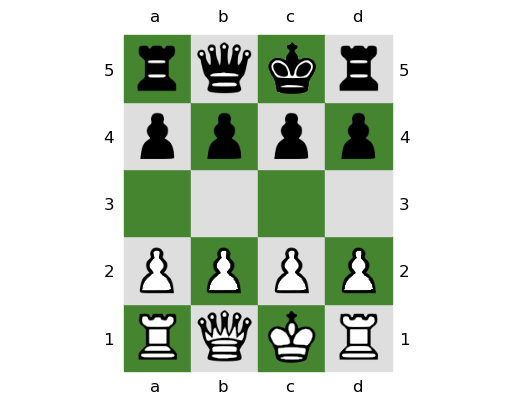

In [245]:
b = Board("RQKRPPPP....pppprqkr")
b.draw()

# Generating next states
The program must be able to consider moving pieces just like a human would. The goal is a function which takes a board state and makes all possible moves.

# Genreiranje 

## Preparation

- The following block contains useful functions called in the "theory" function in charge of generating the first genration of moves.
- Some will be illegal and need to be removed. More on that later.

In [150]:
#used for debugging: marks moves from "moves" on the board
def mark(board, moves):
  for coord in moves:
    x = coord[0]
    y = coord[1]
    board.field[x][y] = '-'

#definiton of p-infinity distance
def dist(p1, p2):
  return max(abs(p1[0]-p2[0]), abs(p1[1]-p2[1]))

#returns coordinates of the suqare one move awaf from the "coord" towards the "origin"
def stepCloser(origin, coord):
  direction = (origin[0]-coord[0],origin[1]-coord[1])
  length = max( abs(direction[0]), abs(direction[1]) )
  normalized = (int(direction[0]/length), int(direction[1]/length))
  return ( normalized[0] + coord[0], normalized[1] + coord[1] )

#check if two squares p1 and p2 hold pieces which are enemies to each other
def foe(board, p1, p2):
  piece1 = board.field[p1[0]][p1[1]]
  piece2 = board.field[p2[0]][p2[1]]
  if(piece1 == '.' or piece2 == '.'):
    return False

  if(color[piece1] != color[piece2]):
    return True
  else:
    return False

#check if two squares p1 and p2 hold pieces of the same color
def friend(board, p1, p2):
  piece1 = board.field[p1[0]][p1[1]]
  piece2 = board.field[p2[0]][p2[1]]
  if(piece1 == '.' or piece2 == '.'):
    return False

  if(color[piece1] == color[piece2]):
    return True
  else:
    return False

#used for eliminating theoretical moves which would result in moving "through" other pieces
#capturing enemies is of course allowed
#the "origin" contains coordinates of the square for whose piece we are filtering moves
def filter(board, origin, moves):
  piece = board.field[origin[0]][origin[1]]
  captures = []
  filtered = []

  for distance in range(1,5):
    for coord in moves:
      
      if(dist(coord,origin) == distance):
        filtered.append(coord)

        if(friend(board, origin, coord) and filtered.count(coord) > 0):
          filtered.remove(coord)

        if(foe(board, origin, coord)):
          captures.append(coord)

        if(distance > 1):
          closer = stepCloser(origin, coord)

          if(filtered.count(closer) == 0 and filtered.count(coord) > 0):
            filtered.remove(coord)

          if(captures.count(closer) > 0 and filtered.count(coord) > 0):
            filtered.remove(coord)

  #special check for castling
  #ignore hypocondition
  if(piece == 'K' and not board.wic):

    hypoConditionW = True

    if(board.castleW[0] and board.castleW[1] and board.field[1][0] == '.' and hypoConditionW): filtered.append((origin[0]-2,origin[1])) #castle left
    if(board.castleW[2] and board.castleW[1]): filtered.append((origin[0]+1,origin[1])) #castle right

  if(piece == 'k' and not board.bic):

    hypoConditionB = True

    if(board.castleB[0] and board.castleB[1] and board.field[1][4] == '.' and hypoConditionB): filtered.append((origin[0]-2,origin[1])) #castle left
    if(board.castleB[2] and board.castleB[1]): filtered.append((origin[0]+1,origin[1])) #castle right
           
  return filtered

- The "theory" is a function for generating theoretical moves ignoring rules regarding "king in check".
- The "coord" holds coordinates of the piece we are considering.

In [151]:
def theory(board, coord):
  piece = board.field[coord[0]][coord[1]]
  moves = ()

  #king case
  if(piece == 'K' or piece == 'k'):
    for i in range(-1,2):
      for j in range(-1,2):
        if(0 <= coord[0] + i <= 3 and 0 <= coord[1] + j <= 4 and (i!=0 or j!=0)):
          moves += ((coord[0] + i, coord[1] + j),)

  #queen case
  elif(piece == 'Q' or piece == 'q'):
    for i in range(-3,4):
      for j in range(-4,5):
        x = i + coord[0]
        y = j + coord[1]
        if(0 <= x <= 3 and 0 <= y <= 4 and (i==0 or j==0) and not(i==j)):
          moves += ((x,y),)
        if(0 <= x <= 3 and 0 <= y <= 4 and i != 0 and abs(j/i) == 1 ):
          moves += ((x,y),)

  #rook case
  elif(piece == 'R' or piece == 'r'):
    for i in range(-3,4):
      for j in range(-4,5):
        x = i + coord[0]
        y = j + coord[1]
        if(0 <= x <= 3 and 0 <= y <= 4 and (i==0 or j==0) and not(i==j)):
          moves += ((x,y),)

  #white pawn case
  elif(piece == 'P'):
    x = coord[0]
    y = coord[1]
    
    if(y<=3 and board.field[x][y+1]=='.'): moves += ((x,y+1),)
    #if it is on starting rank it can move two places forward
    if(y == 1 and board.field[x][y+1]=='.' and board.field[x][y+2]=='.'): moves += ((x,y+2),)

    #if it can capture diagonally
    if(x+1 <= 3 and ( foe(board,(x,y),(x+1,y+1)) or board.enPassantB == (x+1,y+1) )):
      moves += ((x+1,y+1),)
    if( x-1 >= 0 and ( foe(board,(x,y),(x-1,y+1)) or board.enPassantB == (x-1,y+1) )):
        moves += ((x-1,y+1),)

  #black pawn case
  elif(piece == 'p'):
    x = coord[0]
    y = coord[1]
    
    if(y>=1 and board.field[x][y-1]=='.'): moves += ((x,y-1),)
    #if it is on starting rank it can move two places forward
    if(y == 3 and board.field[x][y-1]=='.' and board.field[x][y-2]=='.'): moves += ((x,y-2),)

    #if it can capture diagonally
    if(x+1 <= 3 and foe(board,(x,y),(x+1,y-1))): #add enPassant!
      moves += ((x+1,y-1),)
    if(x-1 >= 0 and foe(board,(x,y),(x-1,y-1))):
        moves += ((x-1,y-1),)
  
  moves = filter(board,coord,moves)

  return moves

Demonstration:
- Squares marked with "-" are the result of the "theory" function being called.

In [152]:
theoryTest = Board(".... ..K. .... q.R. ....")
print(theoryTest)
mvs = theory(theoryTest,(2,3))
mark(theoryTest,mvs)
print(theoryTest)

[]
  +---+---+---+---+
5 |   |   |   |   |
  +---+---+---+---+
4 | q |   | Ʀ |   |
  +---+---+---+---+
3 |   |   |   |   |
  +---+---+---+---+
2 |   |   | ₭ |   |
  +---+---+---+---+
1 |   |   |   |   |
  +---+---+---+---+
    a   b   c   d
[]

[]
  +---+---+---+---+
5 |   |   | - |   |
  +---+---+---+---+
4 | - | - | Ʀ | - |
  +---+---+---+---+
3 |   |   | - |   |
  +---+---+---+---+
2 |   |   | ₭ |   |
  +---+---+---+---+
1 |   |   |   |   |
  +---+---+---+---+
    a   b   c   d
[]



- The "refresh" function will be called every time a piece is moved:
  - to promote pawns on last ranks.
  - to memorize the en passant square if there is one.
  - to update castling rights.
  - to check if kings are in check.

In [153]:

#finds coordinates of the white king
def findWhiteKing(board):
  K = (-1,-1)
  for i in range(0,4):
    for j in range(0,5):
      if(board.field[i][j] == 'K'):
        K = (i,j)
  return K

#finds the coordinates of the black king
def findBlackKing(board):
  k = (-1,-1)
  for i in range(0,4):
    for j in range(0,5):
      if(board.field[i][j] == 'k'):
        k = (i,j)
  return k

#sets the wic/bic class members to True or False
def check(board):
  K = (-1,-1)
  k = (-1,-1)
  K = findWhiteKing(board)
  k = findBlackKing(board)
  board.wic = False
  board.bic = False
  for i in range(0,4):
    for j in range(0,5):

      if(K != (-1,-1) and not board.wic and foe(board,K,(i,j))):
        moves = theory(board,(i,j))
        if(moves.count(K) > 0):
          board.wic = True
          
      if(K != (-1,-1) and not board.bic and foe(board,k,(i,j))):
        moves = theory(board,(i,j))
        if(moves.count(k) > 0):
          board.bic = True

#promotes pawns on last ranks to queens
def promote(board):
  for i in range(0,4):
    if(board.field[i][4] == 'P'):
      board.field[i][4] = 'Q'
    if(board.field[i][0] == 'p'):
      board.field[i][0] = 'q'  

#castles and updates rights according to the rules listed before Board implementation
def castling(board):
  #rook and king switching places if player castled
  #for white
  if(board.field[0][0] == 'K' and board.castleW[0] and board.castleW[1]): board.field[2][0] = 'R' #castling left
  elif(board.field[3][0] == 'K' and board.castleW[2] and board.castleW[1]): board.field[2][0] = 'R' #castling right
  #for black
  if(board.field[0][4] == 'k' and board.castleB[0] and board.castleB[1]): board.field[2][4] = 'r' #castling left
  elif(board.field[3][4] == 'k' and board.castleB[2] and board.castleB[1]): board.field[2][4] = 'r' #castling right

  if(board.castleW[0] and board.field[0][0] != 'R'): board.castleW[0] = False
  if(board.castleW[1] and board.field[2][0] != 'K'): board.castleW[1] = False
  if(board.castleW[2] and board.field[3][0] != 'R'): board.castleW[2] = False

  if(board.castleB[0] and board.field[0][4] != 'r'): board.castleB[0] = False
  if(board.castleB[1] and board.field[2][4] != 'k'): board.castleB[1] = False
  if(board.castleB[2] and board.field[3][4] != 'r'): board.castleB[2] = False

#takes care of en passant rules listed before Board class implementation
def pawns(board):
  foundW = False
  foundB = False

  #capturing the pawn's "ghost" if it moved two squares
  for i in range(0,4):
    if(board.field[i][2] == 'P' and board.enPassantB == (i,2)):
      board.capturedB.append(board.field[i][1])
      board.field[i][1] = '.'
    if(board.field[i][2] == 'p' and board.enPassantW == (i,2)):
      board.capturedW.append(board.field[i][3])
      board.field[i][3] = '.'

  for i in range(0,4):
    if(board.field[i][3] == 'P' and board.pawnsW[i]): #means the first move that pawn made was a double move
      board.enPassantW = (i,2)
      foundW = True
      break
    if(board.field[i][1] == 'p' and board.pawnsB[i]): #means the first move that pawn made was a double move
      board.enPassantB = (i,2)
      foundB = True
      break
  if(not foundW): board.enPassantW = (-1,-1)
  if(not foundB): board.enPassantB = (-1,-1)

  for i in range(0,4):
    if(board.pawnsW[i] and board.field[i][1] != 'P'): board.pawnsW[i] = False
    if(board.pawnsB[i] and board.field[i][3] != 'p'): board.pawnsB[i] = False

#calls everything defined before
def refresh(board):
  #order is important
  promote(board)
  castling(board)
  pawns(board)
  #check is always last
  check(board)

 - The "moveR" function is used for making moves regardless of if they are legal. The "R" stands for refresh which is called after moving the piece to update the state.

In [154]:
def _toggleI(self):
  if(self.toMove == "white"): self.toMove = "black"
  else: self.toMove = "white"

Board.toggleI = _toggleI

#moves a piece from "beg" square to "end" square and calls "refresh"
#and toggles the initiative
def _moveR(self,beg,end):
  new = copy.deepcopy(self)

  captured = new.field[end[0]][end[1]]
  capturing = new.field[beg[0]][beg[1]]
  new.field[end[0]][end[1]] = new.field[beg[0]][beg[1]]
  new.field[beg[0]][beg[1]] = '.'

  if(color[captured] == "black" and color[capturing] == "white"): 
    new.capturedB.append(captured)
  elif(color[captured] == "white" and color[capturing] == "black"): 
    new.capturedW.append(captured)
  refresh(new)

  new.toggleI()

  return new

Board.moveR = _moveR

- Here is a function for generating legal moves. Argument "coord" holds coordinates of the board square for whose piece we want to find legal moves.
- In this case moves which break any rules regarding "king in check" are eliminated.

In [155]:
def legalMoves(board,coord):
  piece = board.field[coord[0]][coord[1]]
  moves = theory(board, coord)

  #remove castling through check
  if(piece == 'K' and moves.count((0,0)) > 0 and coord == (2,0)):
    hboard = board.moveR((2,0),(1,0))
    if(hboard.wic == True): moves.remove((0,0))
  elif(piece == 'k' and moves.count((0,4)) > 0 and coord == (2,4)):
    hboard = board.moveR((2,4),(1,4))
    if(hboard.bic == True): moves.remove((0,4))

  #remove moves which cause checks on the friendly king 
  filtered = []
  if(color[piece]=="white"):
    for move in moves:
      hboard = board.moveR(coord,move)
      if(not hboard.wic): filtered.append(move)
    moves = filtered
  
  if(color[piece]=="black"):
    for move in moves:
      hboard = board.moveR(coord,move)
      if(not hboard.bic): filtered.append(move)
    moves = filtered

  return moves


## The final function

In [156]:
def nextStates(board):
  boards = []
  if(board.toMove == "white"):
    for i in range(0,4):
      for j in range(0,5):
        piece = board.field[i][j]
        if(color[piece] == "white"):
          mvs = legalMoves(board,(i,j))
          for move in mvs:
            new = board.moveR((i,j),move)
            boards.append(new)

  if(board.toMove == "black"):
    for i in range(0,4):
      for j in range(0,5):
        piece = board.field[i][j]
        if(color[piece] == "black"):
          mvs = legalMoves(board,(i,j))
          for move in mvs:
            new = board.moveR((i,j),move)
            boards.append(new)
            
  return boards
          

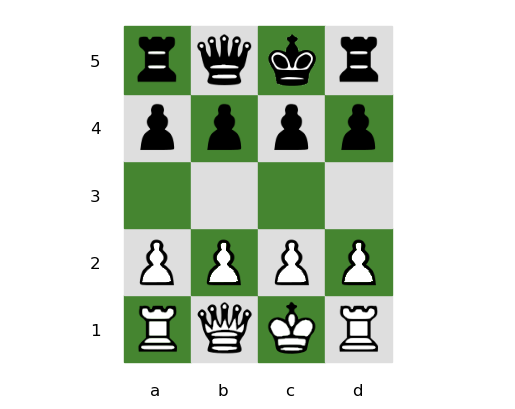

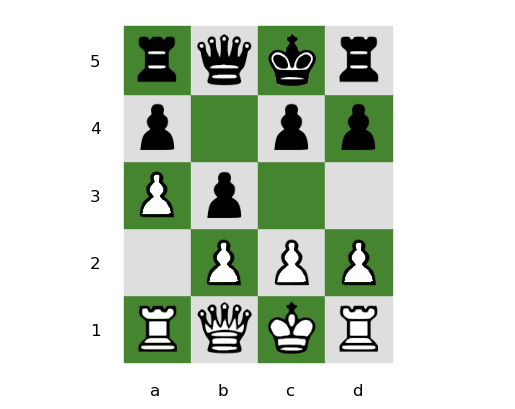

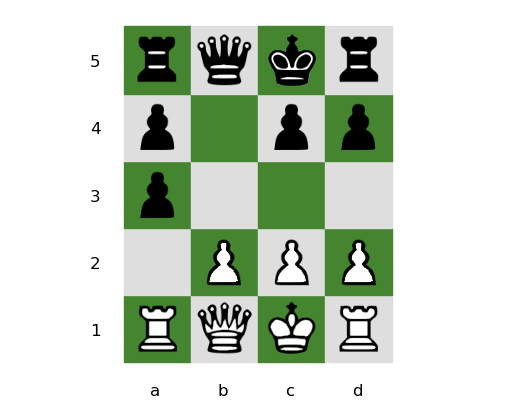

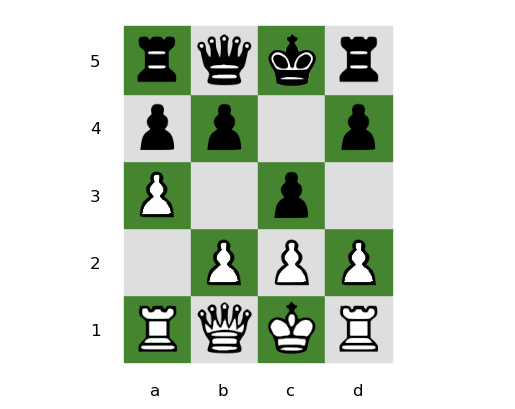

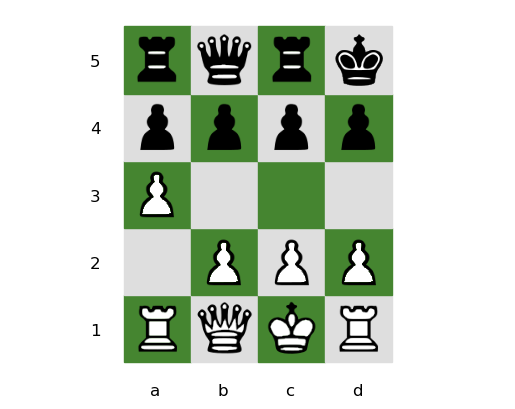

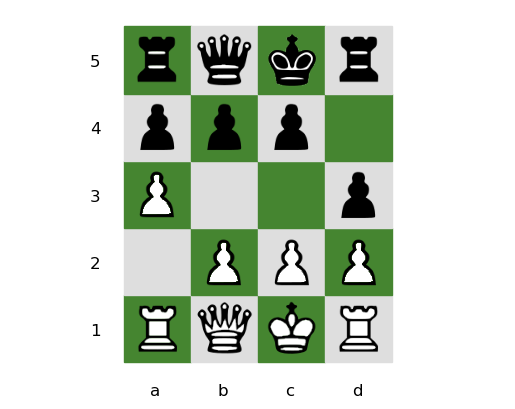

In [157]:
bb = Board("RQKR PPPP .... pppp rqkr")
bb.draw()
bb = bb.moveR((0,1),(0,2))
novi = nextStates(bb)
for b in novi:
  b.draw()

# Heuristics for evaluation
Since the AI will not simulate games untill the end we need a heuristic to judge how good a position is when a certain state tree depth is reached.


- If black has a better position the value will be in the negative and if white has it it will be in the positive.
- Here are some useful functions which will help determine the quality of positions. The "value" functions return the value sum of freindly pieces.

In [158]:
value = {
    #white pieces
    'K': 10,
    'Q': 9,
    'R': 5,
    'P': 1,
    #black pieces
    'k': 10,
    'q': 9,
    'r': 5,
    'p': 1,
}

def valueW(board):
  sum = 0
  for i in range(0,4):
    for j in range(0,5):
      piece = board.field[i][j]
      if(color[piece] == "white"): sum += value[piece]
  return sum

def valueB(board):
  sum = 0
  for i in range(0,4):
    for j in range(0,5):
      piece = board.field[i][j]
      if(color[piece] == "black"): sum += value[piece]
  return sum

## An expensive heuristic
This chapter is not an integral part of the final solution. The games work without it, but it demonstrates a learning process and how an approach to the problem can be modified.
- The problem, as the title might suggest, is that this function is of great complexity and takes too much time to compute a value. Since the number of leaves grows exponentially with depth there is a supstantial decrease in performance when the AI has a task of looking more than three moves ahead.
- Altho the value returned for the position is realistic it turned out that the naive approach explained in the **A CHEAP HEURISTIC** chapter is superior. Especially when the AI has to come up with a checkmate pattern.

- It looks naive to evaluate a position right after a capture if there is a way for the opponent to regain the value balance present before the capture.
- Example:

In [159]:
test = Board(".K.. ..R. .... ..p. ..k.")
refresh(test)
print("white to move\n", test)
print(valueW(test),valueB(test))

white to move
 []
  +---+---+---+---+
5 |   |   | k |   |
  +---+---+---+---+
4 |   |   | i |   |
  +---+---+---+---+
3 |   |   |   |   |
  +---+---+---+---+
2 |   |   | Ʀ |   |
  +---+---+---+---+
1 |   | ₭ |   |   |
  +---+---+---+---+
    a   b   c   d
[]

15 11


- If a state as above was reached at the predefined depth for the min-max algorithm, the max algorithm (from the white's perspective) has to use a heuristic for evaluating the position. Some implementations could suggest that capturing the pawn with the rook is the best move and not consider the black king's option to recapture and actually profit from the trade.
- Note: If the value of the captured piece is (here a pawn) is greater than the value of the capturing piece, there is no problem. That is an acceptable move even if the attacking piece is recaptured.
- A naive solution would be to always run one more iteration of the algorithm within the evaluating funcfion and rule out the moves for which there is an immediate response from the enemy player. Apart from extending thr depth, here is another problem with that approach. Let's explore in the next example.
- Example:

In [160]:
test2 = Board("K.R. .... Q.p. .... ..rk")
refresh(test2)
print("white to move")
print(test2)

white to move
[]
  +---+---+---+---+
5 |   |   | r | k |
  +---+---+---+---+
4 |   |   |   |   |
  +---+---+---+---+
3 | Φ |   | i |   |
  +---+---+---+---+
2 |   |   |   |   |
  +---+---+---+---+
1 | ₭ |   | Ʀ |   |
  +---+---+---+---+
    a   b   c   d
[]



- If we limit our evaluator function's view to just one move response of the enemy player, it might miss opportunities where it is actually acceptable to capture a piece. As we can see in the example above, white can capture the pawn with the rook because there is a white queen on a3 also attacking c3 and if black decides to recapture with the rook on c5 it would only lose more material. 
- There is one problem. It would not make sense for white to capture with the queen first because the immediate response from black would result in white losing 9 points while gaining 1+5 after the complete trade is over. That is why we need an algorithim which will capture with the attacker of least value first. 
- The next blocks of code will try to ensure such functionality. "attackers" functions return a list of attackers on a square with target coordinates.

In [161]:
def _piece(self, coord):
  return self.field[coord[0]][coord[1]]

Board.piece = _piece

def wAttackers(board, target):
  allAttackers = []
  cboard = copy.deepcopy(board)
  cboard.field[target[0]][target[1]] = 'q'

  for level in range(0,4):
    attackers = []
    for i in range(0,4):
      for j in range(0,5):
        piece = cboard.piece((i,j))
        if(color[piece] == "white"):
          lm = legalMoves(cboard, (i,j))
          for move in lm:
            if(move == target): 
              attackers.append((i,j))
              break
    #removing all the attackers from this level and imagining that they got captured in the trade
    #after they are removed there is a potetntial for making space for attackers hidden behind
    for a in attackers:
      cboard.field[a[0]][a[1]] = '.'
    allAttackers.extend(attackers)

  for i in range(0,4):
    for j in range(0,5):
      if(dist((i,j),(target)) == 1 and board.piece((i,j)) == 'K'): allAttackers.append((i,j))

  return allAttackers

def bAttackers(board, target):
  allAttackers = []
  cboard = copy.deepcopy(board)
  cboard.field[target[0]][target[1]] = 'Q'

  for level in range(0,4):
    attackers = []
    for i in range(0,4):
      for j in range(0,5):
        piece = cboard.piece((i,j))
        if(color[piece] == "black"):
          lm = legalMoves(cboard, (i,j))
          for move in lm:
            if(move == target): 
              attackers.append((i,j))
              break
    #removing all the attackers from this level and imagining that they got captured in the trade
    #after they are removed there is a potetntial for making space for attackers hidden behind
    for a in attackers:
      cboard.field[a[0]][a[1]] = '.'
    allAttackers.extend(attackers)

  for i in range(0,4):
    for j in range(0,5):
      if(dist((i,j),(target)) == 1 and board.piece((i,j)) == 'k'): allAttackers.append((i,j))

  return allAttackers

- The attack function finds the lowest value piece (which can attack) in the available list of attackers and simulates the attack. It is color-independent. 

In [162]:
def minValueCoord(board, attackers):
  min = 1001
  minC = (-1,-1)
  for coord in attackers:
    piece = board.piece(coord)
    if(value[piece] < min):
      min = value[piece]
      minC = coord
  return minC

def attack(board, attackers, target):

  attacked = False
  att = copy.deepcopy(attackers)
  new = copy.deepcopy(board)

  while(not attacked and len(att)>0):
    mvc = minValueCoord(board,att)
    lm = legalMoves(board, mvc)

    for move in lm:
      if(move == target):
       new = board.moveR(mvc,target)
       attackers.remove(mvc)
       attacked = True
       break
    if(not attacked): att.remove(mvc)
    
  return [attacked, new]

- The "hanging" functions return True if the friendly piece can safely be captured by the opponent - without losing value in material. 

In [163]:
#provided that black is to move
def hangingW(board, target):
  
  res = [False, copy.deepcopy(board)]
  iBalance = valueW(board) - valueB(board)
  blackWilling = True
  ba = bAttackers(board, target)
  wa = wAttackers(board, target)

  while(len(ba)>0 and blackWilling):
    res = attack(res[1], ba, target)
    if(len(wa)==0 or not res[0]): break
    else:
      res = attack(res[1], wa, target)
      if(not res[0]): break
      balance = valueW(res[1]) - valueB(res[1])
      if(balance < iBalance): blackWilling = False
  
  balance = valueW(res[1]) - valueB(res[1])
  if(balance < iBalance): return True
  else: return False

#provided that white is to move
def hangingB(board, target):
  
  res = [False, copy.deepcopy(board)]
  iBalance = valueW(board) - valueB(board)
  whiteWilling = True
  ba = bAttackers(board, target)
  wa = wAttackers(board, target)

  while(len(wa)>0 and whiteWilling):
    res = attack(res[1], wa, target)
    if(len(ba)==0 or not res[0]): break
    else:
      res = attack(res[1], ba, target)
      if(not res[0]): break
      balance = valueW(res[1]) - valueB(res[1])
      if(balance > iBalance): whiteWilling = False
  
  balance = valueW(res[1]) - valueB(res[1])
  if(balance > iBalance): return True
  else: return False

- The "material" functions return the value sum of friendly pieces but without the most valuable hanging one. Provided that the opponent is to move, the best move they can make is to capture the hanging piece and gain material advantage.

In [164]:
def materialW(board):
  sum = valueW(board) - 10
  hangingValues = []

  for i in range(0,4):
    for j in range(0,5):
      piece = board.piece((i,j))
      if(color[piece] == "white"):
        h = hangingW(board,(i,j))
        if(h): hangingValues.append(value[piece])

  if(len(hangingValues) > 0): sum -= max(hangingValues)
  return sum

def materialB(board):
  sum = valueB(board) - 10
  hangingValues = []

  for i in range(0,4):
    for j in range(0,5):
      piece = board.piece((i,j))
      if(color[piece] == "black"):
        h = hangingB(board,(i,j))
        if(h): hangingValues.append(value[piece])

  if(len(hangingValues) > 0): sum -= max(hangingValues)
  return sum

def hHanging(board):
  if(board.toMove == "black"):
    wm = materialW(board) #since black is to move there might be hanging white pieces
    bm = valueB(board)- 10 #subtracting the king

    return wm - bm

  if(board.toMove == "white"):
    wm = valueW(board) - 10  #subtracting the king 
    bm = materialB(board) #since white is to move there might be hanging white pieces

    return wm - bm

- Example:

In [165]:
g = Board("...R ..K. ...p ..r. ..k.")
g.toMove = "white"
refresh(g)
print("to move:")
print(g.toMove)
print(g)
print("evaluation: ")
print(hHanging(g))

to move:
white
white king in check
[]
  +---+---+---+---+
5 |   |   | k |   |
  +---+---+---+---+
4 |   |   | r |   |
  +---+---+---+---+
3 |   |   |   | i |
  +---+---+---+---+
2 |   |   | ₭ |   |
  +---+---+---+---+
1 |   |   |   | Ʀ |
  +---+---+---+---+
    a   b   c   d
[]

evaluation: 
0


- In the example above the white king can capture the pawn safely and revert the material balance back to 0.
- Example:

In [166]:
g = Board("R.KR PPPP .... .r.. .qk.")
g.toMove = "black"
refresh(g)
print("to move:")
print(g.toMove)
print(g)
print("evaluation: ")
print(hHanging(g))

to move:
black
[]
  +---+---+---+---+
5 |   | q | k |   |
  +---+---+---+---+
4 |   | r |   |   |
  +---+---+---+---+
3 |   |   |   |   |
  +---+---+---+---+
2 | I | I | I | I |
  +---+---+---+---+
1 | Ʀ |   | ₭ | Ʀ |
  +---+---+---+---+
    a   b   c   d
[]

evaluation: 
-1


- In the example above only the white king is defending the b-pawn and there are two black attackers on that file. 

## A cheap heuristic

In [167]:

#returns the difference between piece values of white and black player
def hMaterialSum(board):
  wm = valueW(board) - 10 #subtracting the king
  bm = valueB(board) - 10 #subtracting the king
    
  return wm - bm

#not used
def hKingFreedom(board):
  K = findWhiteKing(board)
  k = findBlackKing(board)
  movesW = legalMoves(board, K)
  movesB = legalMoves(board, k)
  wf = len(movesW)
  bf = len(movesB)

  return (wf - bf)/10 #dividing to normalize: [0,1]

#this function rewards the player who has more
#powerful pieces in the middle of the board
def hCenterDomination(board):
  sumW = 0
  sumB = 0

  p1 = board.field[1][1]
  p2 = board.field[2][1]
  p3 = board.field[1][3]
  p4 = board.field[2][3]

  p5 = board.field[1][2]
  p6 = board.field[2][2]

  L1 = (p1,p2,p3,p4)
  L2 = (p5, p6)
  for p in L1:
    if(color[p]=="white"): sumW += value[p]
    elif(color[p]=="black"): sumB += value[p]
  for p in L2:
    if(color[p]=="white"): sumW += value[p] * 2
    elif(color[p]=="black"): sumB += value[p] * 2
  
  return (sumW - sumB)/50

#having a king in check usually is not desirable
#because it limits movement
def hCheck(board):
  if(board.wic): return -0.9
  if(board.bic): return 0.9
  else: return 0

- This evaluator might have naive goals in the long run, meaning it longs to capture pieces which might not be free to capture. 
- Let "d" be de depth of the state tree the AI explores from position "P". The advantage is that this function makes the AI good at punishing mistakes which lead to material loss within the next d number of moves. 
- If there are "n" defenders of an enemy piece and it turns out that it is "hanging" in position P (meaning it can be captured for free and material advantage can be obtained), then the AI can conclude that it is safe to capture if d >= 2*n + 2
- This way the calculations explored in the **AN EXPENSIVE HEURISTIC** chapter are avoided.
- Another advantage is the ability to find checkmates in d moves. It is demonstrated in **CHECKMATING EXERCISES**.
- When the checkmate is too far to simulate, but the material advantage suggests that it should happen the AI's strategy is to aim for the center and have board control. Then the mate gets closer to P.

## The main heuristic
The "hMain" function is what will be called in further implementations of the game so it is a place to insert evaluators.
- It will contain a linear combination of previously defined board state evaluators.
- The reader can experiment with the expensive evaluator by changing the return value and calling the "hHanging".
- This proposed version sets weights for functions in the combination in a way so that it respects their importance. Smaller weights ensure that every point of advantage from a function of smaller importance does not trump the points from the more important functions. Example:
  - There is no position which would make the AI think it is ok to give up a pawn for central domination. 
  - m(P1) - 1 + c(P2) < m(P1) + c(P1) for every P1 and P2; where m,c are material and centerDomination functions and P1, and P2 are positions.

In [168]:
def hMain(board):
  return hMaterialSum(board) + 0.9*hCenterDomination(board) + 0.01*hCheck(board)

# Min-Max algorithm
Here is an implementation of the well known algorithm from mathematical AI theory.

- The most important return value of the "Min" and "Max" is when a state tree leaf is a checkmate position.
- In the first versions of the code all paths to the checkmate position were considered equally good. The AI was not capable of finding checkmates in one move if the depth limit was set to more than one. The reason was that the order of visiting new states and expanding fronts was not clever, but rather followed a simple pattern of looping through coordinates. The result was finding longer paths to the checkmate. There were positions where the black player allowed white good defense because it was trying to go the "long way". The problem is that it would "forget" the plan it had after a new move was made and new calculations made.
- That is why there is a bonus to the position value. It is a beter position if it was reached higher in the tree.

In [169]:
#it is important that this number is bigger than any evaluation value
CHECK_MATE_CODE = 737

#returns True if there is a check
def mateTest(board):
  if(board.toMove == "black" and board.bic and len(nextStates(board))==0): return True
  if(board.toMove == "white" and board.wic and len(nextStates(board))==0): return True
  return False

#returns True if the max depth is reached
#notice that depth is actually depth_limit minus the depth in the state tree
def depthTest(depth):
  if(depth == 0): return True
  return False

def MinValue(board, alpha, beta, depth, heuristic):
  if(depthTest(depth)): return heuristic(board) 
  if(mateTest(board)): 
    #this was discussed earlier
    if(board.wic): return - CHECK_MATE_CODE - depth
    else: return CHECK_MATE_CODE + depth

  value = 9899 #something bigger than all possible position evaluations
  succs = nextStates(board)
  if(len(succs)==0): return 0;

  for board in succs:
    value = min(value, MaxValue(board, alpha, beta, depth-1, heuristic))
    if(value <= alpha): return value
    beta = min(value, beta)

  return value

def MaxValue(board, alpha, beta, depth, heuristic):
  if(depthTest(depth)): return heuristic(board) 
  if(mateTest(board)): 
    #this was discussed earlier
    if(board.wic): return - CHECK_MATE_CODE - depth
    else: return CHECK_MATE_CODE + depth

  value = -9899 #something smaller than all possible position evaluations
  succs = nextStates(board)
  if(len(succs)==0): return 0; #means it is stalemate position

  for board in succs:
    value = max(value, MinValue(board, alpha, beta, depth-1, heuristic))
    if(value >= beta): return value
    alpha = max(value, alpha)

  return value

def MinMaxBlack(board, depth, heuristic):
  succs = nextStates(board)
  if(board.toMove == "white" or len(succs) == 0):
    print("error")
    return
  bestMove = succs[0]
  minValue = 1001 #something bigger than all possible position evaluations

  for board in succs:
    value = MaxValue(board, -9999, 9999, depth-1, heuristic)
    if(value < minValue): 
      minValue = value
      bestMove = board
  
  print("AI evaluates: ", minValue)
  return bestMove

## Iterative depth Min-Max algorithm
This one is very similar to the previous. The only change is that there are arguments used for checking if the available time has expired every time "MinValue" or "MaxValue" are called. If that is the case the stack is resolved by returning a special code TIME_ABORT_CODE to the first call in the recursion. Such a state tree will not be considered valid and its partial result will not be used in "MinMAx".

In [170]:
TIME_ABORT_CODE = 888
CHECK_MATE_CODE = 737

def mateTest(board):
  if(board.toMove == "black" and board.bic and len(nextStates(board))==0): return True
  if(board.toMove == "white" and board.wic and len(nextStates(board))==0): return True
  return False

def depthTest(depth):
  if(depth == 0): return True
  return False

def timeEndTest(startTime, timeLimit):
  if(time.time()-startTime > timeLimit): return True
  else: return False

def MinValueTime(board, alpha, beta, depth, heuristic, startTime, timeLimit):
  if(time.time() - startTime > timeLimit): return TIME_ABORT_CODE
  if(depthTest(depth)): return heuristic(board) 
  if(mateTest(board)): 
    if(board.wic): return - CHECK_MATE_CODE - depth
    else: return CHECK_MATE_CODE + depth

  value = 9899 #something bigger than all possible position evaluations
  succs = nextStates(board)
  if(len(succs)==0): return 0;

  for board in succs:
    maxCandidate = MaxValueTime(board, alpha, beta, depth-1, heuristic, startTime, timeLimit)
    if(maxCandidate == TIME_ABORT_CODE): return TIME_ABORT_CODE
    value = min(value, maxCandidate)
    if(value <= alpha): return value
    beta = min(value, beta)

  return value

def MaxValueTime(board, alpha, beta, depth, heuristic, startTime, timeLimit):
  if(time.time() - startTime > timeLimit): return TIME_ABORT_CODE
  if(depthTest(depth)): return heuristic(board) 
  if(mateTest(board)): 
    if(board.wic): return - CHECK_MATE_CODE - depth
    else: return CHECK_MATE_CODE + depth

  value = -9899 #something smaller than all possible position evaluations
  succs = nextStates(board)
  if(len(succs)==0): return 0; #means it is stalemate position

  for board in succs:
    minCandidate = MinValueTime(board, alpha, beta, depth-1, heuristic, startTime, timeLimit)
    if(minCandidate == TIME_ABORT_CODE): return TIME_ABORT_CODE
    value = max(value, minCandidate)
    if(value >= beta): return value
    alpha = max(value, alpha)

  return value

def MinMaxBlackTime(board, depth, heuristic, startTime, timeLimit):
  succs = nextStates(board)
  if(board.toMove == "white" or len(succs) == 0):
    print("error")
    return
  bestMove = succs[0]
  minValue = 1001 #something bigger than all possible position evaluations

  for board in succs:
    value = MaxValueTime(board, -9999, 9999, depth-1, heuristic, startTime, timeLimit)
    if(value == TIME_ABORT_CODE): return TIME_ABORT_CODE
    if(value < minValue): 
      minValue = value
      bestMove = board
  
  #print(minValue)
  return bestMove

import time

def MinMaxBlackIterative(board, heuristic, timeLimit):
  timeLimit = max(2, timeLimit)
  startTime = time.time()
  currentTime = startTime
  depth = 1
  while(currentTime - startTime < timeLimit):
    bestMoveCandidate = MinMaxBlackTime(board, depth, heuristic, startTime, timeLimit)
    if(bestMoveCandidate == TIME_ABORT_CODE): break
    finishedDepth = depth
    bestMove = bestMoveCandidate
    currentTime = time.time()
    depth += 1

  print("finished depth: ", finishedDepth)
  return bestMove

# Setting up Player vs AI
We need to create an interface for communication between the AI and the user.


The "Interface" function has many redundancies and could be written in a more elegant way, but it works.

In [171]:
moveType = {
    "a": 0,
    "b": 1,
    "c": 2,
    "d": 3,

    "1": 0,
    "2": 1,
    "3": 2,
    "4": 3,
    "5": 4,
}

#turns a string into a move used for program logic
def genMove(input):
  #input must be legal
  p1 = (moveType[input[0]], moveType[input[1]])
  p2 = (moveType[input[2]], moveType[input[3]])
  move = (p1, p2)
  return move

def makeMove(board, move):
  #move must be legal
  new = board.moveR(move[0],move[1])
  return new

#checks if a move breaks game rules
def legalMove(board, move):
  lm = legalMoves(board, move[0])
  c = lm.count(move[1])
  if(c == 0):
    return False
  return True

#checks if user input breaks interface and game rules
def legalString(board, input):
  if(len(str(input)) != 4): return False
  files = ["a","b","c","d"]
  ranks = ["1","2","3","4","5"]
  a = files.count(input[0])
  c = files.count(input[2])
  b = ranks.count(input[1])
  d = ranks.count(input[3])
  if(a==0 or b==0 or c==0 or d==0): return False
  
  move = genMove(input)
  if(not legalMove(board, move)): return False

  return True

from IPython.display import clear_output

def Interface():
  if(run == False): return

  #initialization
  b = Board(startingPosition)
  b.toMove = "white"
  refresh(b)
  print(b)

  # FIRST MOVE:
  move = input("Your move: ")
  if(move == "exit" or move == "surrender"): 
    print("BLACK WINS!")
    return
  if(not legalString(b, move)):
    while(not legalString(b, move)):
      print("Invalid input! Try again.")
      move = input("Your move: ")
      if(move == "exit" or move == "surrender"): 
        print("BLACK WINS!")
        return

  move = genMove(move)
  playerState = makeMove(b, move)
  print(playerState)

  #checking for game end
  if(len(nextStates(playerState)) == 0):
      if(playerState.bic):
        print("WHITE WINS!")
      else:
        print("STALEMATE!")

  print("AI calculating...")
  AIState = MinMaxBlack(playerState, depth, hMain)
  print(AIState)

  #checking for game end
  if(len(nextStates(AIState)) == 0):
      if(AIState.wic):
        print("BLACK WINS!")
      else:
        print("STALEMATE!")

  # MAIN GAME LOOP:
  while(True):
    move = input("Your move: ")
    if(move == "exit" or move == "surrender"): 
      print("BLACK WINS!")
      return
    if(not legalString(AIState, move)):
      while(not legalString(AIState, move)):
        print("Invalid input! Try again.")
        move = input("Your move: ")
        if(move == "exit" or move == "surrender"): 
          print("BLACK WINS!")
          return
    move = genMove(move)
    playerState = makeMove(AIState, move)

    clear_output()
    print(playerState)

    #checking for game end
    if(len(nextStates(playerState)) == 0):
      if(playerState.bic):
        print("WHITE WINS!")
        break
      else:
        print("STALEMATE!")
        break 

    print("AI calculating...")
    AIState = MinMaxBlack(playerState, depth, hMain)
    print(AIState)

    #checking for game end
    if(len(nextStates(AIState)) == 0):
      if(AIState.wic):
        print("BLACK WINS!")
        break
      else:
        print("STALEMATE!")
        break

  return

- This next version of the interface has a functionality to control the move timer for the AI.
- The iterative depth version called "MinMaxBlackIterative" of the min-max algorithm is used for generating the response from AI to the given positions. The "moveTime" is passed as the argument for limiting calculation time.

In [172]:
def InterfaceTime():
  if(run == False): return

  #initialization
  b = Board(startingPosition)
  b.toMove = "white"
  refresh(b)
  print(b)

  #first move
  move = input("Your move: ")
  if(move == "exit" or move == "surrender"): 
    print("BLACK WINS!")
    return
  if(not legalString(b, move)):
    while(not legalString(b, move)):
      print("Invalid input! Try again.")
      move = input("Your move: ")
      if(move == "exit" or move == "surrender"): 
        print("BLACK WINS!")
        return

  move = genMove(move)
  playerState = makeMove(b, move)
  print(playerState)

  #checking for game end
  if(len(nextStates(playerState)) == 0):
      if(playerState.bic):
        print("WHITE WINS!")
      else:
        print("STALEMATE!")

  print("AI calculating...")
  AIState = MinMaxBlackIterative(playerState, hMain, moveTime)
  print(AIState)

  #checking for game end
  if(len(nextStates(AIState)) == 0):
      if(AIState.wic):
        print("BLACK WINS!")
      else:
        print("STALEMATE!")

  #main game loop
  while(True):
    move = input("Your move: ")
    if(move == "exit" or move == "surrender"): 
      print("BLACK WINS!")
      return
    if(not legalString(AIState, move)):
      while(not legalString(AIState, move)):
        print("Invalid input! Try again.")
        move = input("Your move: ")
        if(move == "exit" or move == "surrender"): 
          print("BLACK WINS!")
          return

    move = genMove(move)
    playerState = makeMove(AIState, move)

    clear_output()
    print(playerState)

    #checking for game end
    if(len(nextStates(playerState)) == 0):
      if(playerState.bic):
        print("WHITE WINS!")
        break
      else:
        print("STALEMATE!")
        break 

    print("AI calculating...")
    AIState = MinMaxBlackIterative(playerState, hMain, moveTime)
    print(AIState)

    #checking for game end
    if(len(nextStates(AIState)) == 0):
      if(AIState.wic):
        print("BLACK WINS!")
        break
      else:
        print("STALEMATE!")
        break

  return

# Checkmating exercises
In this section we will explore if the AI is capable of pulling off some common checkmating ideas.

- The reader is welcome to try to defend or stalemate the position for white.
- **Manual:**
- To run the game set the "run" parameter to True and to prevent the game from running set it to False.
- For more info on controls visit the **PLAYER VS AI RULES** section
- The "depth" parameter describes how many moves ahead the AI for the black player explores.
- The depth of 5 was optimal for the upcoming examples. It could be incresed, but mind the exponential complexity. 

In [173]:
# CHECKMATING WITH A QUEEN
run = False
depth = 5
startingPosition = ("q... .k.. .... .... ..K.")
Interface()

In [174]:
# CHECKMATING WITH A ROOK
run = False
depth = 5
startingPosition = ("k... .r.. .... .... ..K.")
Interface()

- In the next example we have a position where if the black player is not careful enough they could throw a guaranteed win by naively pushing the pawn to the promotion rank without protecting it with their king.
- A minimum depth of 5 is required for black to win.

In [188]:
# CHECKMATING WITH A PAWN
run = True
depth = 6
startingPosition = (".... .... ..p. K.k. ....")
Interface()

[]
  +---+---+---+---+
5 |   |   |   |   |
  +---+---+---+---+
4 |   | q |   |   |
  +---+---+---+---+
3 |   |   |   |   |
  +---+---+---+---+
2 | ₭ |   |   | k |
  +---+---+---+---+
1 |   |   |   |   |
  +---+---+---+---+
    a   b   c   d
[]

AI calculating...
AI evaluates:  -740
[]
  +---+---+---+---+
5 |   |   |   |   |
  +---+---+---+---+
4 |   | q |   |   |
  +---+---+---+---+
3 |   |   |   |   |
  +---+---+---+---+
2 | ₭ |   |   |   |
  +---+---+---+---+
1 |   |   | k |   |
  +---+---+---+---+
    a   b   c   d
[]

Your move: exit
BLACK WINS!


#Player vs AI rules
- **MANUAL:**
- To run the game set the "run" parameter to True and to prevent the game from running set it to False. Then run the cell.
- The "moveTime" parameter describes the maximum time in seconds the AI can use to generate a move. 
- The more time the AI has to think the better the move it makes will be. After it makes a move it will print out how many moves ahead it checked out.
- The "startingPostion" can be changed if a player wishes to start from a custom one
  - See notes in **BOARD CREATION** section for info on piece and board representation.
- Above the board there is a list of captured white pieces. Below the board the same for black.
- When prompted with the "Your move:" box, enter a string representing Your move following these rules:
  - Only 4 characters are allowed.
  - The first two characters represent the coordinates of the piece to move.
  - The last two characters represent the target location for the moved piece.
  - Example: "a2a3" moves the piece on a2 to a3.
- After making a move the board state will be shown at the top and the AI will generate its response and print it out.
- To exit the game type "exit" or "surrender" instead of the move.

- **SILVERMANN CHESS 4X5 GAME RULES:**
- The game follows classic chess rules. These are the only changes:
  - Pawns can only promote to a queen.
  - Castling is done by switching places with the rook. Other rules regarding castling are unchanged.
  - A pawn can move two squares forward for its first move only if there is no piece ocupying the target square. En passant capturing is allowed after that.
- The default starting position looks like shown below.
  - From left to right major pieces are ROOK, QUEEN, KING, ROOK.
  - On he first rank are white pieces and the fifth black.
  - The second rank contains white pawns.
  - The fourth rank contains black pawns.

In [176]:
exampleBoard = Board("RQKR PPPP .... pppp rqkr")
print(exampleBoard)

[]
  +---+---+---+---+
5 | r | q | k | r |
  +---+---+---+---+
4 | i | i | i | i |
  +---+---+---+---+
3 |   |   |   |   |
  +---+---+---+---+
2 | I | I | I | I |
  +---+---+---+---+
1 | Ʀ | Φ | ₭ | Ʀ |
  +---+---+---+---+
    a   b   c   d
[]



# The game
- Before calling the "Interface" function variables "run, depth and startingPosition" have to be initialized.
- Before calling the "InterfaceTime" function variables "run, moveTime and startingPosition" have to be initialized.

## Time limit version

In [177]:
run = False
moveTime = 5
startingPosition = "RQKR PPPP .... pppp rqkr"

InterfaceTime()

## Depth limit version


These tests were done using free colab resources on the standard starting position.
- The depth limit:
  - 4: response in under 5 seconds
  - 5: reponse in under 20 seconds
  - 7: response in around 5 minutes 

In [178]:
run = False
depth = 4
startingPosition = "RQKR PPPP .... pppp rqkr"

Interface()

#  Dodatak

In [179]:
import matplotlib.image as img
import matplotlib.pyplot as plt
from matplotlib.offsetbox import (OffsetImage, AnnotationBbox)
import matplotlib.ticker as ticker

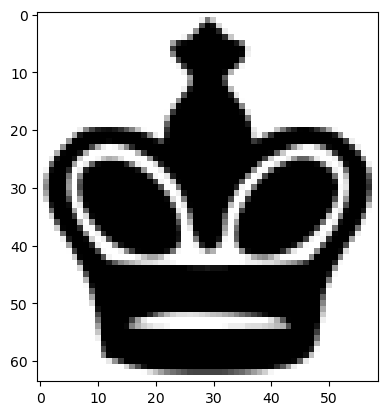

In [180]:
file = "./assets/black-king.png"
bk = img.imread(file)
plt.imshow(bk)

In [181]:
col = {
   -1 : (0.87,0.87,0.87),
    1 : "#458530"
}

In [182]:
imagebox = OffsetImage(icon['K'], zoom=0.6)
ab = AnnotationBbox(imagebox,(3,1),frameon=False)
ax.add_artist(ab)

In [184]:
icon = {
    'K' : bk
}

In [186]:
def _draw(self):
    board_figure, board_ax = plt.subplots()
    board_ax.axis('equal')
    board_ax.axis('off')
    d = 0.5
    toggle = -1
    for c in range(1, 5, 1):
        for r in range(1, 6, 1):
            toggle *= -1
            x = [c-d,c+d,c+d,c-d]
            y = [r-d,r-d,r+d,r+d]
            board_ax.fill(x,y,color=col[toggle])
            imagebox = OffsetImage(icon[self.field[c-1][r-1]], zoom=0.6)
            ab = AnnotationBbox(imagebox,(c,r), frameon=False)
            board_ax.add_artist(ab)